# HSCT survival: XGBoost ensemble

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

import configuration as config
import functions.helper as helper_funcs
import functions.plotting as plot_funcs

notebook_num='03.3'
gpu=0

# Data files
datasets_file=f'{config.PROCESSED_DATA}/02.1-dataset_definitions.pkl'
coxph_survival_file=f'{config.PROCESSED_DATA}/02.1-coxPH_survival.pkl'
weibullaft_survival_file=f'{config.PROCESSED_DATA}/02.2-weibullAFT_survival.pkl'
learned_efs_file=f'{config.PROCESSED_DATA}/02.4-learned_efs.pkl'

# Model files
tuned_model_file=f'{config.MODELS_PATH}/{notebook_num}-XGBoost_engineered_features_tuned.pkl'

# Experiment results
hyperparameter_tuning_results=f'{config.DATA_PATH}/results/data/{notebook_num}-hyperparameter_tuning_results.csv'
training_scores_file=f'{config.DATA_PATH}/results/data/{notebook_num}-training_scores.csv'
testing_scores_file=f'{config.DATA_PATH}/results/data/{notebook_num}-testing_scores.csv'

retune_model=True

## 1. Load data

In [2]:
# Read the dataset metadata
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

# Load one of the datasets
with open(datasets['Nominal one-hot/ordinal encoded, NANs imputed'], 'rb') as input_file:
    data_dict=pickle.load(input_file)

print('Data dictionary contains:\n')
for key, value in data_dict.items():
    print(f' {key}: {type(value)}')

# Load Cox Proportional Hazard model features
with open(coxph_survival_file, 'rb') as input_file:
    coxph_features=pickle.load(input_file)

print('\nCox PH features:\n')
for key, value in coxph_features.items():
    print(f' {key}: {type(value)}')

# Load Weibull Accelerated Failure Time model features
with open(weibullaft_survival_file, 'rb') as input_file:
    weibullaft_features=pickle.load(input_file)

print('\nWeibull AFT features:\n')
for key, value in weibullaft_features.items():
    print(f' {key}: {type(value)}')

# Load learned efs features
with open(learned_efs_file, 'rb') as input_file:
    learned_efs_features=pickle.load(input_file)

print('\nLearned EFS features:\n')
for key, value in learned_efs_features.items():
    print(f' {key}: {type(value)}')

Data dictionary contains:

 Training features: <class 'pandas.core.frame.DataFrame'>
 Training labels: <class 'pandas.core.frame.DataFrame'>
 Training IDs: <class 'list'>
 Training race group: <class 'list'>
 Testing features: <class 'pandas.core.frame.DataFrame'>
 Testing labels: <class 'pandas.core.frame.DataFrame'>
 Testing IDs: <class 'list'>
 Testing race group: <class 'list'>

Cox PH features:

 Training survival: <class 'list'>
 Training partial hazard: <class 'list'>
 Testing survival: <class 'list'>
 Testing partial hazard: <class 'list'>

Weibull AFT features:

 Training survival: <class 'list'>
 Training expectation: <class 'list'>
 Testing survival: <class 'list'>
 Testing expectation: <class 'list'>

Learned EFS features:

 Training efs probability: <class 'numpy.ndarray'>
 Testing efs probability: <class 'numpy.ndarray'>


## 2. Data preparation

### 2.1. Add survival model features

In [3]:
training_features_df=data_dict['Training features']
training_features_df['CoxPH survival']=coxph_features['Training survival']
training_features_df['CoxPH partial hazard']=coxph_features['Training partial hazard']
training_features_df['WeibullAFT survival']=weibullaft_features['Training survival']
training_features_df['WeibullAFT expectation']=weibullaft_features['Training expectation']

testing_features_df=data_dict['Testing features']
testing_features_df['CoxPH survival']=coxph_features['Testing survival']
testing_features_df['CoxPH partial hazard']=coxph_features['Testing partial hazard']
testing_features_df['WeibullAFT survival']=weibullaft_features['Testing survival']
testing_features_df['WeibullAFT expectation']=weibullaft_features['Testing expectation']

training_features_df.head().transpose()

,0,1,2,3,4
psych_disturb_1.0,0.000000,0.000000,0.000000,0.000000,0.000000
psych_disturb_2.0,0.000000,0.000000,0.000000,0.000000,1.000000
diabetes_1.0,1.000000,0.000000,0.000000,1.000000,0.000000
diabetes_2.0,0.000000,0.000000,0.000000,0.000000,1.000000
tbi_status_1.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
age_at_hct,45.076000,40.851000,34.568000,52.419000,55.890000
CoxPH survival,0.243637,0.363744,0.516802,0.194666,0.388247
CoxPH partial hazard,1.880348,1.346671,0.878995,2.179151,1.259862
WeibullAFT survival,0.063881,0.099494,0.268041,0.013788,0.146418


### 2.2. Add learned EFS features

In [4]:
training_features_df['learned_efs']=learned_efs_features['Training efs probability']
testing_features_df['learned_efs']=learned_efs_features['Testing efs probability']

training_features_df.head().transpose()

,0,1,2,3,4
psych_disturb_1.0,0.000000,0.000000,0.000000,0.000000,0.000000
psych_disturb_2.0,0.000000,0.000000,0.000000,0.000000,1.000000
diabetes_1.0,1.000000,0.000000,0.000000,1.000000,0.000000
diabetes_2.0,0.000000,0.000000,0.000000,0.000000,1.000000
tbi_status_1.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
CoxPH survival,0.243637,0.363744,0.516802,0.194666,0.388247
CoxPH partial hazard,1.880348,1.346671,0.878995,2.179151,1.259862
WeibullAFT survival,0.063881,0.099494,0.268041,0.013788,0.146418
WeibullAFT expectation,46.464758,59.920349,135.041976,24.464473,78.127198


### 2.3. Load labels, race group and ID

In [5]:
training_labels_df=data_dict['Training labels']
training_labels_df['efs_time']=np.log(training_labels_df['efs_time'])
training_race_groups=data_dict['Training race group']
training_ids=data_dict['Training IDs']

testing_labels_df=data_dict['Testing labels']
testing_labels_df['efs_time']=np.log(testing_labels_df['efs_time'])
testing_race_groups=data_dict['Testing race group']
testing_ids=data_dict['Testing IDs']

## 3. XGBoost regression ensemble model

### 3.1. Training

In [6]:
def train_ensemble(
        training_features_df:pd.DataFrame,
        training_labels_df:pd.DataFrame,
        label:str,
        n:int, 
        hyperparameters:dict
) -> list:

    training_df=pd.concat([training_features_df, training_labels_df], axis=1)
    splitter=ShuffleSplit(n_splits=n, test_size=.8)
    models=[]

    for i, (training_idx, validation_idx) in enumerate(splitter.split(training_df)):

        print(f'Fold {i}')

        # Get the features for this fold
        training_features=training_df.iloc[training_idx].drop(['efs', 'efs_time'], axis=1)
        validation_features=training_df.iloc[validation_idx].drop(['efs', 'efs_time'], axis=1)

        # Get the labels
        training_labels=training_df.iloc[training_idx][label]
        validation_labels=training_df.iloc[validation_idx][label]

        dtraining=xgb.DMatrix(
            training_features,
            label=training_labels
        )
        dvalidation=xgb.DMatrix(
            validation_features,
            label=validation_labels
        )

        tree_model=xgb.train(
            hyperparameters,
            dtraining,
            num_boost_round=10000,
            evals=[(dvalidation, 'validation')],
            early_stopping_rounds=500,
            verbose_eval=1
        )

        models.append(tree_model)

    return models

In [7]:
%%time

hyperparameters={
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 6,
    'gamma': 0.01,
    'subsample': 0.5
}

if gpu != None:
    hyperparameters['gpu_id']=gpu
    hyperparameters['tree_method']='gpu_hist'

models=train_ensemble(training_features_df, training_labels_df, 'efs_time', 10, hyperparameters)
print()

Fold 0
[0]	validation-rmse:2.33225
[1]	validation-rmse:2.31238
[2]	validation-rmse:2.29244
[3]	validation-rmse:2.27307
[4]	validation-rmse:2.25359
[5]	validation-rmse:2.23438
[6]	validation-rmse:2.21576
[7]	validation-rmse:2.19700
[8]	validation-rmse:2.17850
[9]	validation-rmse:2.16011
[10]	validation-rmse:2.14212
[11]	validation-rmse:2.12410
[12]	validation-rmse:2.10630
[13]	validation-rmse:2.08890
[14]	validation-rmse:2.07146
[15]	validation-rmse:2.05444
[16]	validation-rmse:2.03753
[17]	validation-rmse:2.02079
[18]	validation-rmse:2.00411
[19]	validation-rmse:1.98764
[20]	validation-rmse:1.97170
[21]	validation-rmse:1.95590
[22]	validation-rmse:1.94046
[23]	validation-rmse:1.92445
[24]	validation-rmse:1.90921
[25]	validation-rmse:1.89413
[26]	validation-rmse:1.87883
[27]	validation-rmse:1.86382
[28]	validation-rmse:1.84917
[29]	validation-rmse:1.83459
[30]	validation-rmse:1.82010
[31]	validation-rmse:1.80585
[32]	validation-rmse:1.79164
[33]	validation-rmse:1.77773
[34]	validation-r

### 3.2. Predictions

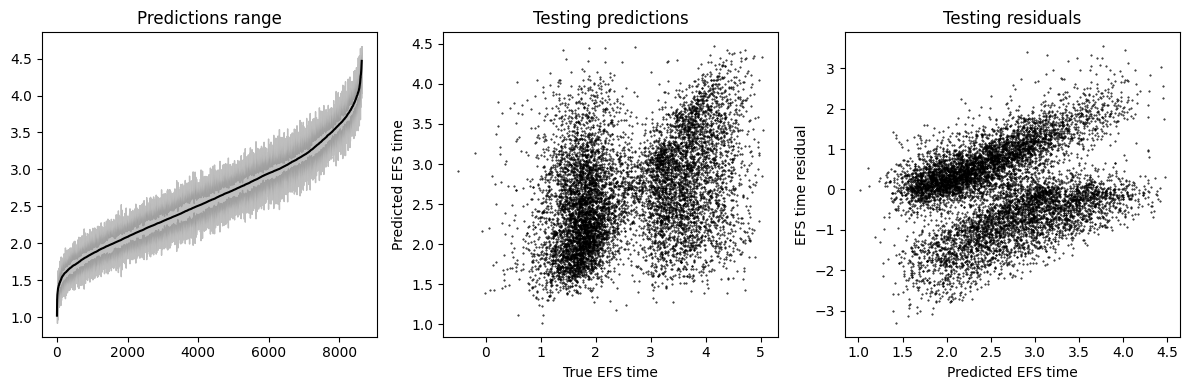

In [8]:
dtesting=xgb.DMatrix(
    testing_features_df,
    label=testing_labels_df['efs_time']
)
testing_predictions=[]

for model in models:
    testing_predictions.append(model.predict(dtesting))

mean_testing_predictions=np.mean(np.array(testing_predictions), axis=0).flatten()
std_testing_predictions=np.std(np.array(testing_predictions), axis=0).flatten()
predictions_df=pd.DataFrame.from_dict({'prediction': mean_testing_predictions, 'std': std_testing_predictions})
predictions_df.sort_values('prediction', inplace=True)

# Calculate fit residuals
testing_residuals=mean_testing_predictions - testing_labels_df['efs_time']

fig, axs=plt.subplots(1,3, figsize=(12,4))
axs=axs.flatten()

axs[0].set_title('Predictions range')
axs[0].plot(list(range(len(predictions_df))), predictions_df['prediction'], color='black')
axs[0].fill_between(
    list(range(len(predictions_df))),
    predictions_df['prediction'] - predictions_df['std'],
    predictions_df['prediction'] + predictions_df['std'],
    color='grey',
    alpha=0.5
)

axs[1].set_title('Testing predictions')
axs[1].scatter(testing_labels_df['efs_time'], mean_testing_predictions, color='black', s=0.2)
axs[1].set_xlabel('True EFS time')
axs[1].set_ylabel('Predicted EFS time')

axs[2].set_title('Testing residuals')
axs[2].scatter(mean_testing_predictions, testing_residuals, color='black', s=0.2)
axs[2].set_xlabel('Predicted EFS time')
axs[2].set_ylabel('EFS time residual')

fig.tight_layout()
fig.show()

### 4.3. Scoring

In [9]:
score_results=helper_funcs.score_predictions(
    'Mean testing predictions',
    mean_testing_predictions,
    testing_labels_df['efs_time'].values,
    testing_labels_df['efs'].values,
    testing_race_groups,
    testing_ids
)

score_results_df=pd.DataFrame(score_results)
score_results_df.head()

,Model,RMSE,C-index,Stratified C-index
0,Mean testing predictions,0.997367,0.64624,0.632364


## 4. XGBoost classification ensemble

### 4.1. Training

In [10]:
%%time

hyperparameters={
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.01,
    'max_depth': 6,
    'gamma': 0.01,
    'subsample': 0.5
}

if gpu != None:
    hyperparameters['gpu_id']=gpu
    hyperparameters['tree_method']='gpu_hist'

models=train_ensemble(training_features_df.drop('learned_efs', axis=1), training_labels_df, 'efs', 10, hyperparameters)
print()

Fold 0
[0]	validation-logloss:0.69151
[1]	validation-logloss:0.68985
[2]	validation-logloss:0.68845
[3]	validation-logloss:0.68691
[4]	validation-logloss:0.68532
[5]	validation-logloss:0.68379
[6]	validation-logloss:0.68243
[7]	validation-logloss:0.68104
[8]	validation-logloss:0.67952
[9]	validation-logloss:0.67811
[10]	validation-logloss:0.67680
[11]	validation-logloss:0.67549
[12]	validation-logloss:0.67422
[13]	validation-logloss:0.67299
[14]	validation-logloss:0.67174
[15]	validation-logloss:0.67042
[16]	validation-logloss:0.66922
[17]	validation-logloss:0.66799
[18]	validation-logloss:0.66682
[19]	validation-logloss:0.66555
[20]	validation-logloss:0.66436
[21]	validation-logloss:0.66330
[22]	validation-logloss:0.66226
[23]	validation-logloss:0.66125
[24]	validation-logloss:0.66016
[25]	validation-logloss:0.65919
[26]	validation-logloss:0.65812
[27]	validation-logloss:0.65709
[28]	validation-logloss:0.65614
[29]	validation-logloss:0.65522
[30]	validation-logloss:0.65424
[31]	valida

In [11]:
dtesting=xgb.DMatrix(
    testing_features_df.drop('learned_efs', axis=1),
    label=testing_labels_df['efs_time']
)
testing_predictions=[]

for model in models:
    testing_predictions.append(model.predict(dtesting))

mean_testing_predictions=np.mean(np.array(testing_predictions), axis=0).flatten()
std_testing_predictions=np.std(np.array(testing_predictions), axis=0).flatten()
predictions_df=pd.DataFrame.from_dict({'prediction': mean_testing_predictions, 'std': std_testing_predictions})
predictions_df.sort_values('prediction', inplace=True)
predictions_df.head()

,prediction,std
5245,0.043880,0.014574
4750,0.043946,0.013457
4163,0.044848,0.013298
6070,0.046615,0.023874
3945,0.048236,0.019440


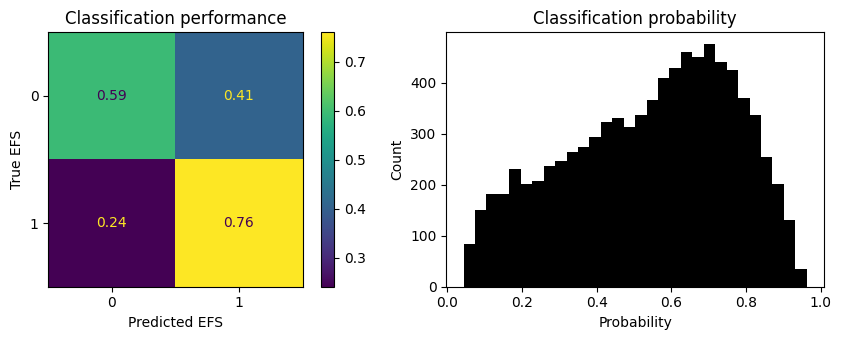

: 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs=plt.subplots(1,2, figsize=(9,3.5))
axs=axs.flatten()

# Make calls with threshold
calls=np.where(mean_testing_predictions < 0.5, 0, 1)

# Plot the confusion matrix
cm=confusion_matrix(testing_labels_df['efs'], calls, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot(ax=axs[0])

axs[0].set_title('Classification performance')
axs[0].set_xlabel('Predicted EFS')
axs[0].set_ylabel('True EFS')

axs[1].set_title('Classification probability')
axs[1].hist(mean_testing_predictions, bins=30, color='black')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Count')

fig.tight_layout()
fig.show()